In [1]:
# Install or upgrade the numexpr package
!pip install --upgrade numexpr

# Import pandas for data manipulation and analysis
import pandas as pd  # Data manipulation and analysis library

# Import json for working with JSON data
import json  # Library for JSON manipulation

#Import datetime to convert date
import datetime

# Import matplotlib.pyplot for creating visualizations
import matplotlib.pyplot as plt  # Plotting library

# Import seaborn for statistical data visualization
import seaborn as sns  # Statistical data visualization library

# Import LabelEncoder from scikit-learn for encoding labels
from sklearn.preprocessing import LabelEncoder  # Encoder for categorical features

# Import seasonal_decompose from statsmodels for seasonal 4 year analysis
from statsmodels.tsa.seasonal import seasonal_decompose

#Import plot_acf and plot_pacf from statsmodels for correlation
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Import necessary libraries from SageMaker
import sagemaker  # Main SageMaker module
from sagemaker import get_execution_role  # Function to get the SageMaker execution role
from sagemaker.image_uris import retrieve  # Function to retrieve container image URIs
from sagemaker.estimator import Estimator  # Estimator class for training models

# Import boto3 library for interacting with AWS services
import boto3  # AWS SDK for Python
from botocore.exceptions import ClientError  # Exception class for handling client errors

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [2]:
# Load the BTC-USD.csv data into a pandas DataFrame
btc_data = pd.read_csv('BTC-USD (6).csv')

In [3]:
# Display the first few rows of the df_onlineretail DataFrame
print(btc_data.head())# Display the first few rows of the df_BTC DataFrame

         Date        Open        High         Low       Close   Adj Close  \
0  2014-09-17  465.864014  468.174011  452.421997  457.334015  457.334015   
1  2014-09-18  456.859985  456.859985  413.104004  424.440002  424.440002   
2  2014-09-19  424.102997  427.834991  384.532013  394.795990  394.795990   
3  2014-09-20  394.673004  423.295990  389.882996  408.903992  408.903992   
4  2014-09-21  408.084991  412.425995  393.181000  398.821014  398.821014   

     Volume  
0  21056800  
1  34483200  
2  37919700  
3  36863600  
4  26580100  


In [4]:
# Display the number of rows and columns in the df_BTC DataFrame
print(btc_data.shape)

(3506, 7)


In [5]:
# Drop the specified columns from df_BTC
columns_to_drop = ['High', 'Low', 'Close', 'Open', 'Volume']
btc_data.drop(columns=columns_to_drop, axis=1, inplace=True)

In [6]:
# Display the number of rows and columns in the df_BTC DataFrame after dropping columns
print(btc_data.shape)

(3506, 2)


In [7]:
# Assuming 'btc_data' is your DataFrame and it includes a column 'Adj Close' for Bitcoin's closing prices
btc_data['30_day_moving_avg'] = btc_data['Adj Close'].rolling(window=30).mean()

In [8]:
# Display a concise summary of the df_BTC DataFrame
print(btc_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3506 entries, 0 to 3505
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Date               3506 non-null   object 
 1   Adj Close          3506 non-null   float64
 2   30_day_moving_avg  3477 non-null   float64
dtypes: float64(2), object(1)
memory usage: 82.3+ KB
None


In [9]:
# Calculate the number of missing values in each column
missing_values = btc_data.isnull().sum()

# Print the number of missing values for each column
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 Date                  0
Adj Close             0
30_day_moving_avg    29
dtype: int64


In [10]:
btc_data.dropna(subset=['30_day_moving_avg'], inplace=True)

In [11]:
# Calculate the number of missing values in each column
missing_values = btc_data.isnull().sum()

# Print the number of missing values for each column
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 Date                 0
Adj Close            0
30_day_moving_avg    0
dtype: int64


In [12]:
# Filter out rows with negative prices or volume
negative_prices = btc_data[btc_data['Adj Close'] < 0]

# Print rows with negative prices
if not negative_prices.empty:
    print("Rows with negative Prices:")
    print(negative_prices)
else:
    print("There are no negative Prices.")

There are no negative Prices.


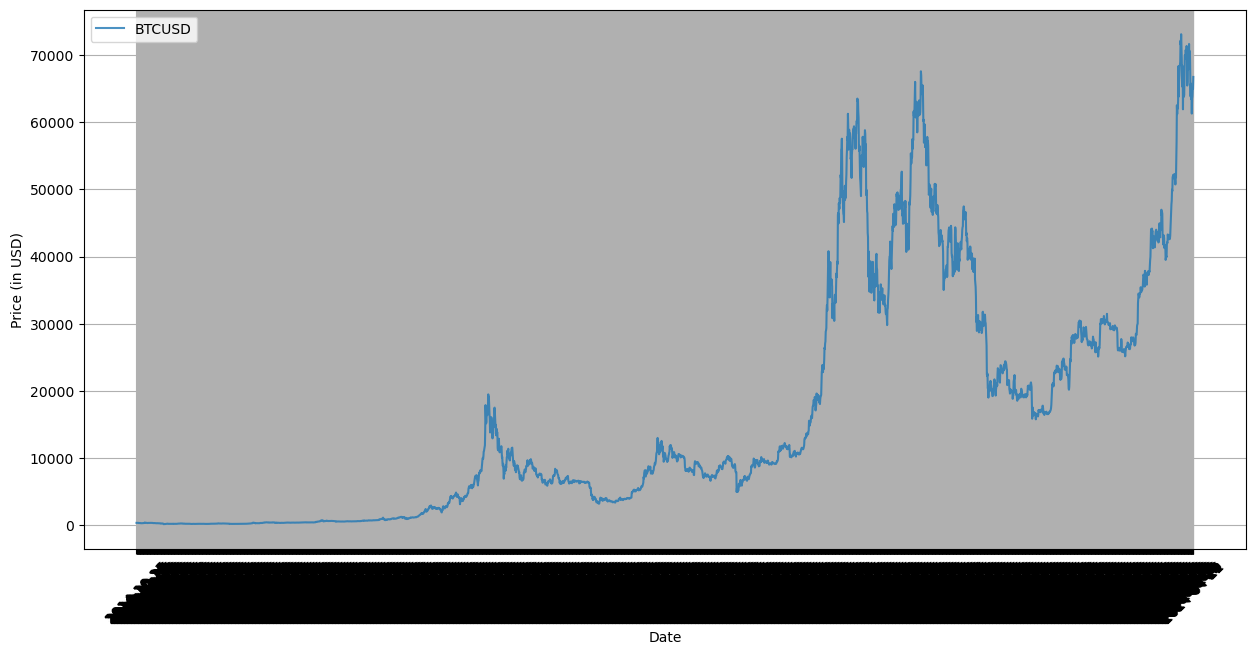

In [13]:
plt.figure(figsize=(15, 7))
plt.plot(btc_data['Date'], btc_data['Adj Close'], label='BTCUSD', alpha=0.8)
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Price (in USD)')
plt.legend()
plt.grid(True)
plt.show()

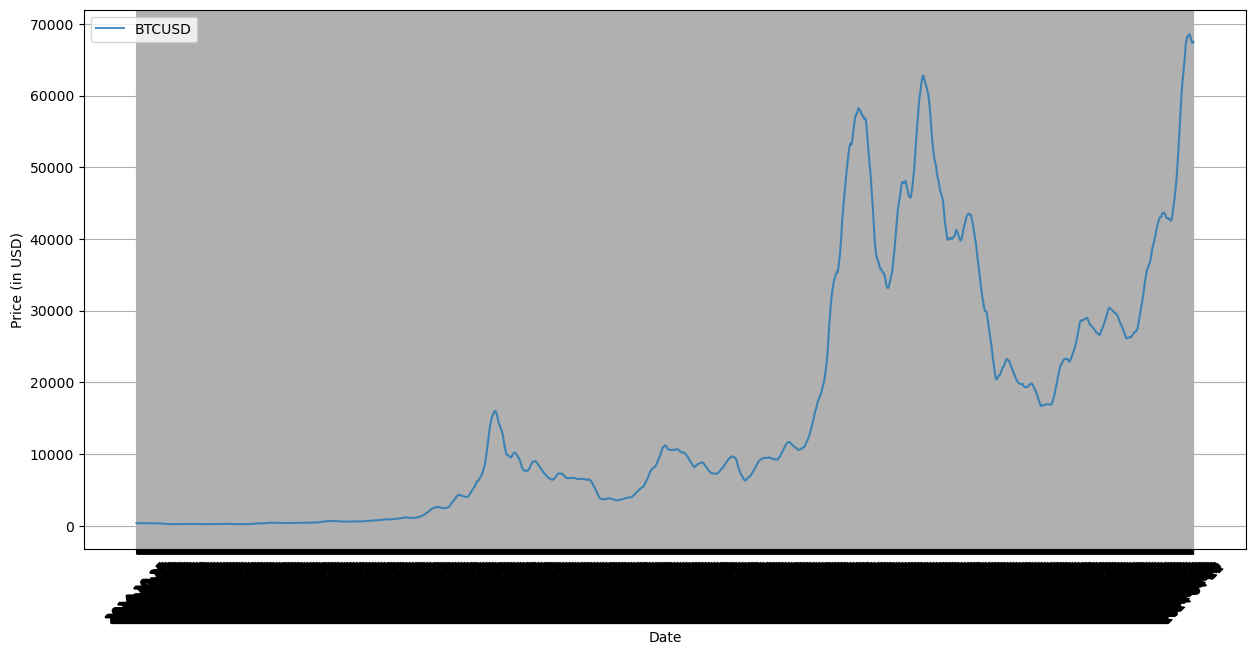

In [14]:
plt.figure(figsize=(15, 7))
plt.plot(btc_data['Date'], btc_data['30_day_moving_avg'], label='BTCUSD', alpha=0.8)
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Price (in USD)')
plt.legend()
plt.grid(True)
plt.show()

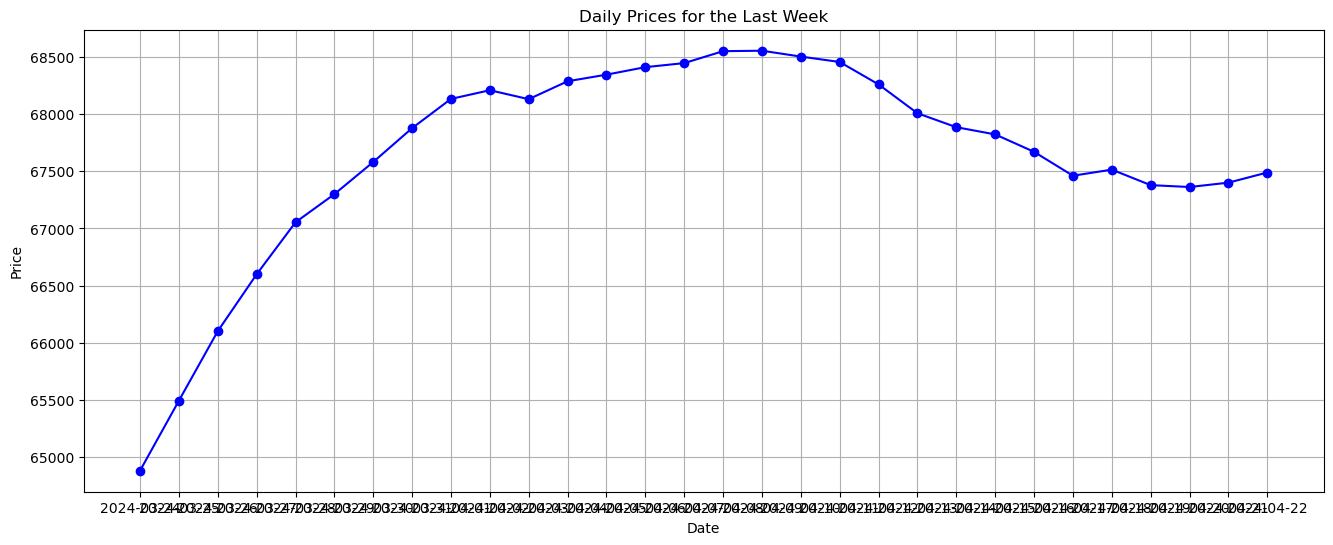

In [15]:
# Plot the daily price data for the last week with markers for each data point

# Slice the daily_sales DataFrame to include only the last week's worth of data
last_month_price = btc_data['30_day_moving_avg'].tail(30)
last_month_date = btc_data['Date'].tail(30)

# Create a new figure for the plot with a specified size
plt.figure(figsize=(16, 6))

# 'InvoiceDate' is on the x-axis, 'Sales' is on the y-axis
# Marker style is set to 'o' (circle), line color is set to blue, and line style is set to solid
plt.plot(last_month_date, last_month_price, marker='o', color='b', linestyle='-')

# Set the title of the plot
plt.title('Daily Prices for the Last Week')

# Set the label for the x-axis
plt.xlabel('Date')

# Set the label for the y-axis
plt.ylabel('Price')

# Add gridlines to the plot
plt.grid(True)

# Display the plot
plt.show()

In [16]:
# Define a function to convert a pandas Series to a JSON object for DeepAR
def series_to_json_obj(series):
    """
    Converts a pandas Series to a JSON object for DeepAR.

    Parameters:
    series (pandas.Series): The time series data.

    Returns:
    dict: A JSON object with "start" and "target" keys.
    """
    # DeepAR expects each time series to be a JSON object with "start" and "target" keys
    return {"start": str(series.index[0]), "target": list(series)}

# Convert 'Date' to datetime format right at the DataFrame creation or modification
btc_data['Date'] = pd.to_datetime(btc_data['Date'])

split_index = int(len(btc_data) * 0.8)
train_data = btc_data.iloc[:split_index]
test_data = btc_data.iloc[split_index:]

# Convert the training data to JSON format for DeepAR
train_series_json = train_data.set_index('Date')['30_day_moving_avg'].pipe(series_to_json_obj)

# Convert the test data to JSON format for DeepAR
test_series_json = test_data.set_index('Date')['30_day_moving_avg'].pipe(series_to_json_obj)

# Save the training data JSON object to a file
with open('train_data.json', 'w') as f:
    json.dump(train_series_json, f)

# Save the test data JSON object to a file
with open('test_data.json', 'w') as f:
    json.dump(test_series_json, f)

In [17]:
# Create a SageMaker session for managing interactions with the SageMaker environment
sagemaker_session = sagemaker.Session()

# Retrieve the execution role for the current SageMaker notebook instance
role = get_execution_role()

# Retrieve the AWS region name from the SageMaker session
region = sagemaker_session.boto_region_name

# Specify the DeepAR container image URI for the specified region
image_uri = retrieve('forecasting-deepar', region)

# Define the default Amazon S3 bucket for the SageMaker session
bucket = sagemaker_session.default_bucket()

# Define the prefix for the S3 key where data will be stored
prefix = 'sagemaker/BTC/basic-prediction'

# Define the path to the local training data file
local_train = 'train_data.json'

# Define the path to the local validation data file
local_validation = 'test_data.json'

# Upload the local training data file to the specified S3 bucket and prefix, returning the S3 URI
train_uri = sagemaker_session.upload_data(local_train, bucket=bucket, key_prefix=prefix)

# Upload the local validation data file to the specified S3 bucket and prefix, returning the S3 URI
test_uri = sagemaker_session.upload_data(local_validation, bucket=bucket, key_prefix=prefix)

# Print the execution role ARN, AWS region name, and S3 URIs for the training and validation data
print("Execution Role ARN:", role)
print("AWS Region:", region)
print("Training Data S3 URI:", train_uri)
print("Validation Data S3 URI:", test_uri)

Execution Role ARN: arn:aws:iam::471112913372:role/LabRole
AWS Region: us-east-1
Training Data S3 URI: s3://sagemaker-us-east-1-471112913372/sagemaker/BTC/basic-prediction/train_data.json
Validation Data S3 URI: s3://sagemaker-us-east-1-471112913372/sagemaker/BTC/basic-prediction/test_data.json


In [18]:
# Define an Estimator for the DeepAR algorithm in SageMaker
deepar_estimator = Estimator(
    sagemaker_session=sagemaker_session,  # Specify the SageMaker session
    image_uri=image_uri,  # Specify the container image URI for the DeepAR algorithm
    role=role,  # Specify the IAM role ARN used by SageMaker
    instance_count=1,  # Specify the number of instances to use for training
    instance_type='ml.m5.large',  # Specify the instance type for training
    output_path=f's3://{bucket}/{prefix}/output',  # Specify the S3 location for saving the model artifacts and output
    base_job_name='BTC-basic'  # Specify the base job name for the training job
)

# Set hyperparameters for the DeepAR algorithm
deepar_estimator.set_hyperparameters(
    time_freq='D',  # Specify the time frequency of the data (e.g., 'D' for daily)
    context_length=30,  # Specify the length of the context used for training (e.g., 30 days)
    prediction_length=7,  # Specify the length of the prediction horizon (forecasting 7 days into the future)
    epochs=100,  # Specify the number of training epochs
    early_stopping_patience=20,  # Specify the number of epochs with no improvement before early stopping
    cardinality='auto'  # Automatically detect the cardinality of categorical features (if any)
)

In [19]:
# Define data channels for training the DeepAR estimator
# Mapping 'train' and 'test' keys to the S3 URIs of the training and test data
data_channels = {
    'train': train_uri,  # Specify the S3 URI for the training data
    'test': test_uri     # Specify the S3 URI for the test data
}

# Fit the DeepAR estimator using the specified data channels
# This step initiates the training job in SageMaker
deepar_estimator.fit(inputs=data_channels)

INFO:sagemaker:Creating training-job with name: BTC-basic-2024-04-22-23-52-10-175


2024-04-22 23:52:10 Starting - Starting the training job...
2024-04-22 23:52:25 Starting - Preparing the instances for training...
2024-04-22 23:53:08 Downloading - Downloading input data......
2024-04-22 23:53:48 Downloading - Downloading the training image........Docker entrypoint called with argument(s): train
Running default environment configuration script
Running custom environment configuration script
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
[04/22/2024 23:55:20 INFO 139929223214912] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'auto', '_num_kv_servers': 'auto', '_tuning_objective_metric': '', 'cardinality': 'auto', 'dropout_rate': '0.10', 'early_stopping_patience': '', 'embedding_dimension': '10', 'learning_rate': '0.001', 'likelihood': 'student-t', 'mini_b

In [23]:
# Specify the endpoint name
endpoint_name = 'BTC-endpoint'

# Specify the endpoint configuration name
endpoint_config_name = 'BTC-endpoint'

# Create a SageMaker client
sagemaker_client = boto3.client('sagemaker')

In [24]:
# Check if the endpoint configuration already exists
try:
    sagemaker_client.describe_endpoint_config(EndpointConfigName=endpoint_config_name)
    print(f'Endpoint configuration "{endpoint_config_name}" already exists. Deleting...')
    sagemaker_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
    print(f'Endpoint configuration "{endpoint_config_name}" deleted.')
except ClientError as e:
    if e.response['Error']['Code'] == 'ValidationException':
        print(f'Endpoint configuration "{endpoint_config_name}" does not exist.')

Endpoint configuration "BTC-endpoint" does not exist.


In [25]:
# Deploy the trained model to an endpoint
predictor = deepar_estimator.deploy(
    initial_instance_count=1,  # Specify the initial number of instances for the endpoint
    instance_type='ml.m5.large',  # Specify the instance type for the endpoint
    serializer=sagemaker.serializers.JSONSerializer(),  # Specify the serializer for the input data
    deserializer=sagemaker.deserializers.JSONDeserializer(),  # Specify the deserializer for the output data
    endpoint_name=endpoint_name,  # Specify the name of the endpoint
)

# Print the endpoint name and endpoint configuration name
print(f'Endpoint name: {predictor.endpoint_name}')
print(f'Endpoint configuration name: {endpoint_config_name}')

INFO:sagemaker:Creating model with name: BTC-basic-2024-04-23-00-02-53-854
INFO:sagemaker:Creating endpoint-config with name BTC-endpoint
INFO:sagemaker:Creating endpoint with name BTC-endpoint


-------!Endpoint name: BTC-endpoint
Endpoint configuration name: BTC-endpoint


In [26]:
# Define the endpoint name
endpoint_name = 'BTC-endpoint'

# Set the prediction length and start date
prediction_length = 7
prediction_start_date = pd.Timestamp('2024-04-15')

# Prepare the prediction input without categorical or dynamic features
prediction_input = {
    "instances": [{
        "start": str(btc_data['Date'].min()),
        "target": btc_data['Adj Close'].tolist() * prediction_length
    }],
    "configuration": {"num_samples": 100, "output_types": ["mean", "quantiles"], "quantiles": ["0.1", "0.9"]}
}

# Invoke the endpoint for prediction
sagemaker_runtime = boto3.client('sagemaker-runtime')
response = sagemaker_runtime.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType='application/json',
    Body=json.dumps(prediction_input)
)

# Parse the prediction response
predictions = json.loads(response['Body'].read().decode())
predicted_means = predictions['predictions'][0]['mean']
predicted_quantiles = predictions['predictions'][0]['quantiles']
predicted_lower_quantile = predicted_quantiles['0.1']
predicted_upper_quantile = predicted_quantiles['0.9']

# Create a DataFrame for the predicted sales
predicted_dates = pd.date_range(start=prediction_start_date, periods=prediction_length, freq='D')
predicted_price = pd.DataFrame({
    'Date': predicted_dates,
    'Predicted Price': predicted_means,
    'Lower Quantile': predicted_lower_quantile,
    'Upper Quantile': predicted_upper_quantile
})

# Display the predicted prices
print(predicted_price)

        Date  Predicted Price  Lower Quantile  Upper Quantile
0 2024-04-15     63343.238281    61895.789062    64747.804688
1 2024-04-16     63448.074219    62261.253906    64682.984375
2 2024-04-17     63242.171875    61889.156250    64604.613281
3 2024-04-18     64236.546875    63043.628906    65718.398438
4 2024-04-19     64166.890625    62832.562500    65548.203125
5 2024-04-20     64432.679688    63152.433594    65632.093750
6 2024-04-21     64750.613281    63389.238281    66472.664062


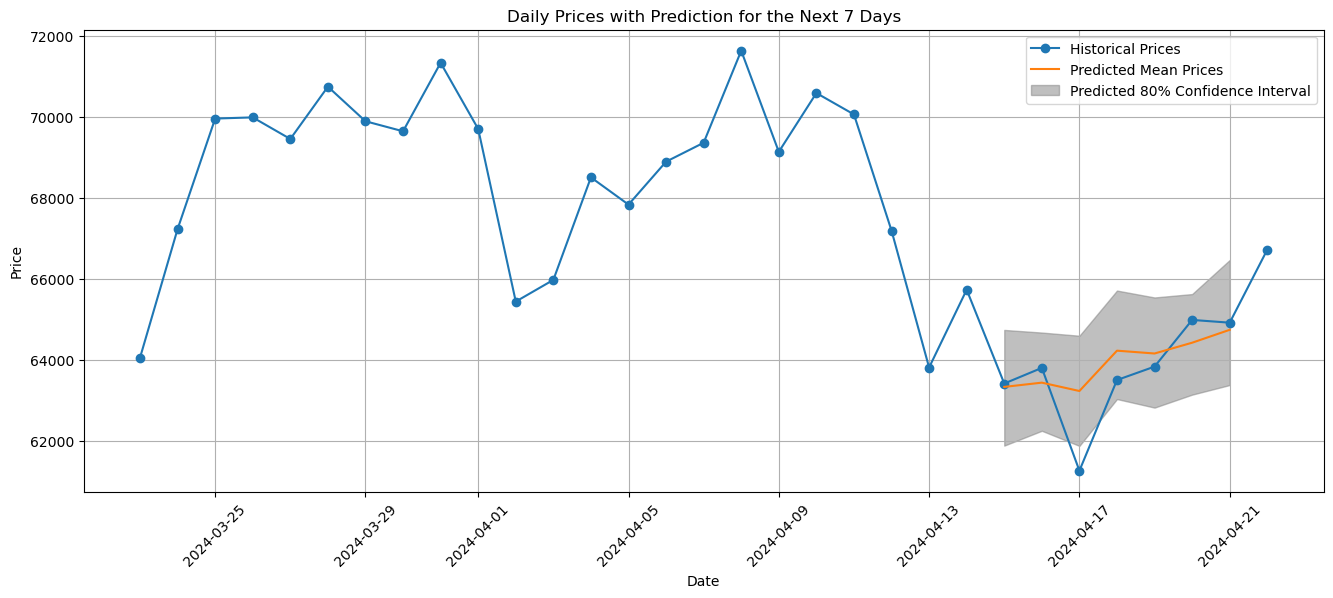

In [27]:
# Convert 'Date' to datetime type
btc_data['Date'] = pd.to_datetime(btc_data['Date'])

# Filter the historical data to include only the last 30 days
last_30_days_price = btc_data[btc_data['Date'] >= (btc_data['Date'].max() - pd.Timedelta(days=30))]

# Plot the daily sales for the last 30 days
plt.figure(figsize=(16, 6))
plt.plot(last_30_days_price['Date'], last_30_days_price['Adj Close'], marker='o', linestyle='-', label='Historical Prices')

# Plot the predicted mean sales
plt.plot(predicted_dates, predicted_means, label='Predicted Mean Prices')

# Plot the predicted quantiles as a shaded area
plt.fill_between(predicted_dates, predicted_lower_quantile, predicted_upper_quantile, color='gray', alpha=0.5, label='Predicted 80% Confidence Interval')

# Add labels and title
plt.title('Daily Prices with Prediction for the Next 7 Days')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
# Prompt for confirmation before deleting the endpoint and endpoint configuration
confirmation = input("Are you sure you want to delete the endpoint and endpoint configuration? (yes/no): ")

if confirmation.lower() == 'yes':
    # Check if the endpoint configuration already exists
    try:
        sagemaker_client.describe_endpoint_config(EndpointConfigName=endpoint_config_name)
        print(f'Endpoint configuration "{endpoint_config_name}" already exists. Deleting...')
        sagemaker_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
        print(f'Endpoint configuration "{endpoint_config_name}" deleted.')
    except ClientError as e:
        if e.response['Error']['Code'] == 'ValidationException':
            print(f'Endpoint configuration "{endpoint_config_name}" does not exist.')
        else:
            raise

    # Check if the endpoint already exists
    try:
        sagemaker_client.describe_endpoint(EndpointName=endpoint_name)
        print(f'Endpoint "{endpoint_name}" already exists. Deleting...')
        sagemaker_client.delete_endpoint(EndpointName=endpoint_name)
        print(f'Endpoint "{endpoint_name}" deleted.')
    except ClientError as e:
        if e.response['Error']['Code'] == 'ValidationException':
            print(f'Endpoint "{endpoint_name}" does not exist.')
        else:
            raise
else:
    print("Deletion cancelled.")